### Importing libraries

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, BackupAndRestore, TensorBoard, CSVLogger
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import os

### Defining Global variables

In [4]:
data_path = "dataset"

In [5]:
IMG_SIZE = [224,224,3]
BATCH_SIZE = 32
NUM_OF_CLASSES = 4

### Dataset

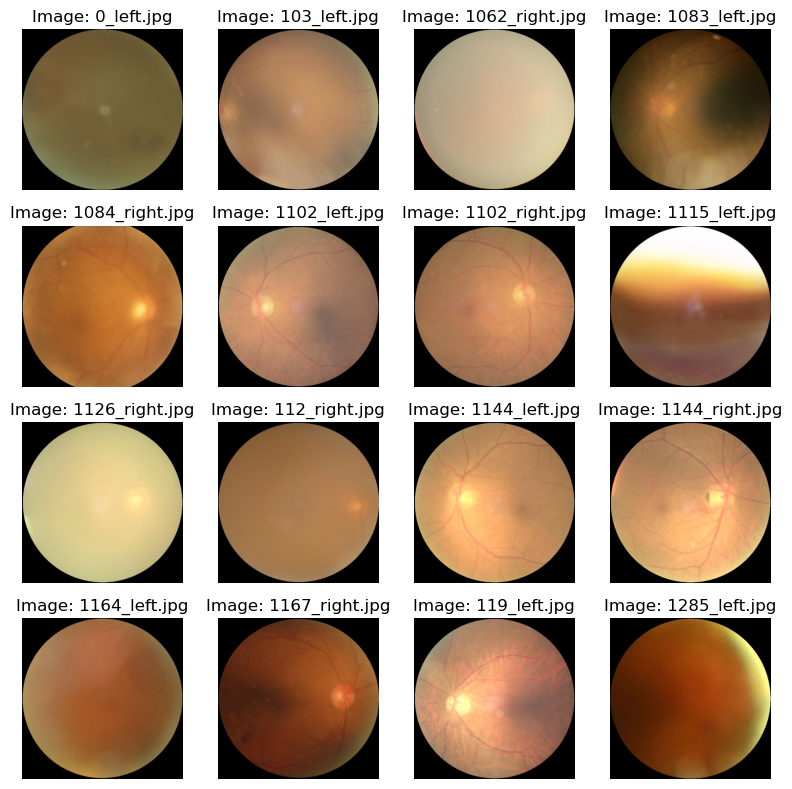

In [12]:
folder_path = "dataset/cataract"
image_filenames = os.listdir(folder_path)
image_filenames = image_filenames[:16]
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, filename in enumerate(image_filenames):
    image_path = os.path.join(folder_path, filename)
    img = Image.open(image_path)
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].set_title(f"Image: {filename}")
    axes[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()

### Data augumentation

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2 
)

In [35]:
train_set = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training', 
    shuffle=True,  
)

Found 3376 images belonging to 4 classes.


In [36]:
test_set = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  
    shuffle=False, 
)

Found 841 images belonging to 4 classes.


### Transfer Learning in VGG16

In [37]:
vgg16 = VGG16(input_shape=IMG_SIZE, weights='imagenet', include_top=False)

In [38]:
for layer in vgg16.layers:
    layer.trainable = False

In [39]:
folders = glob('dataset/*')

In [40]:
# our layers
x = Flatten()(vgg16.output)

In [41]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Callbacks


In [43]:
BUR_callback = BackupAndRestore(backup_dir="./temp1/backup", save_freq='epoch',
                                delete_checkpoint=True,)

In [44]:
early_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,
                                start_from_epoch=2)

In [45]:
csvlog_callback = CSVLogger(
    'logger.csv', separator=',', append=False
)

In [46]:
import tensorflow as tf

decay_steps = 3  # Number of epochs before reducing the learning rate
decay_rate = tf.math.exp(-0.1)  # The factor by which the learning rate will be reduced

def lr_scheduler(epoch, lr):
    if epoch % decay_steps == 0 and epoch > 0:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

In [47]:
checkpoint_filepath = '/temp1/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


### Compilation and Fitting

In [50]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0005),
  metrics=['accuracy'],
)

In [51]:
# fit the model

r = model.fit(
  train_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set),
  callbacks=[BUR_callback, csvlog_callback, lr_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/30
106/106 [==============================] - 278s 3s/step - loss: 0.7398 - accuracy: 0.6943 - val_loss: 0.9448 - val_accuracy: 0.6409 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/30
106/106 [==============================] - 262s 2s/step - loss: 0.5617 - accuracy: 0.7793 - val_loss: 0.6428 - val_accuracy: 0.7503 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/30
106/106 [==============================] - 259s 2s/step - loss: 0.4514 - accuracy: 0.8303 - val_loss: 0.6556 - val_accuracy: 0.7372 - lr: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0004524187243077904.
Epoch 4/30
106/106 [==============================] - 267s 3s/step - loss: 0.4303 - accuracy: 0.8377 - val_loss: 0.6925 - val_accuracy: 0.7265 - lr: 4.5242e-04

Epoch 5: LearningRateScheduler setting 

### Data Visualization

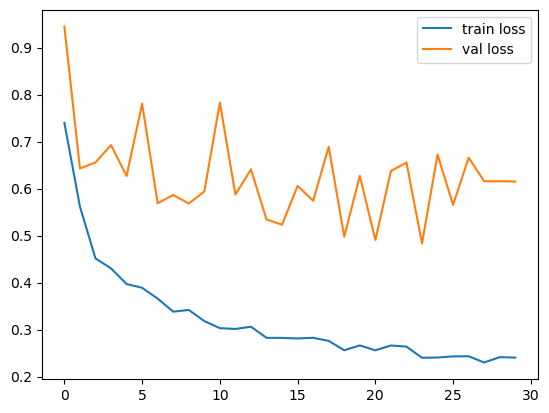

<Figure size 640x480 with 0 Axes>

In [52]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

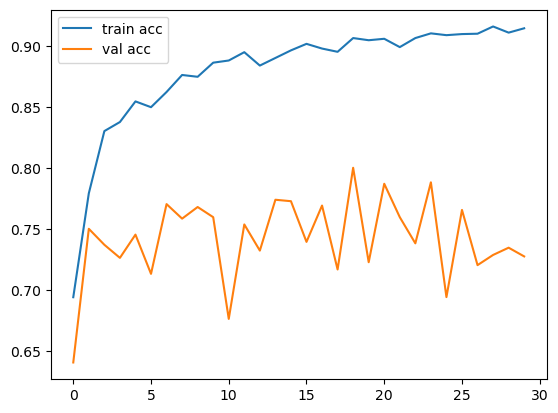

<Figure size 640x480 with 0 Axes>

In [53]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### Creating h5 file

In [54]:
from tensorflow.keras.models import load_model
model.save('model_vgg16.h5')

### Session closing

In [55]:
InteractiveSession.close(session)